In [63]:
from data import KelpNCDataset
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import xarray as xr
import pandas as pd

In [40]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN


def dbscan_knee_plot(X: np.ndarray, eps: float = None, ax: plt.Axes = None) -> int:
    """ Generate knee plot with DBSCAN to guess a good epsilon threshold. Pick eps at the knee. """
    # Dimensionality of data
    n, d = X.shape
    min_pts = (2 * d) + 1  # +1 to include point itself
    min_pts = min(n, min_pts)
    k_nn = 2 * d  # (2 * d - 1) from Schubert et al (2017)
    k_nn = min(n, k_nn)
    print(f"Based on dimensionality, use min_pts={min_pts}!")

    nn = NearestNeighbors(n_neighbors=min_pts)
    nn.fit(X)
    nn_dist, _ = nn.kneighbors(X, k_nn, return_distance=True)
    nn_dist = np.sort(nn_dist[:, -1])[::-1]

    if ax is None:
        fig, ax = plt.subplots()

    ax.plot(nn_dist)
    if eps is not None:
        ax.hlines(eps, 0, len(nn_dist), color="red")

    try:
        # Only show if generated inside function
        fig.show()
    except NameError:
        ...

    return min_pts

In [92]:
kelp = KelpNCDataset(img_nc_path="data_ncf/train_imgs_fe.nc", mask_nc_path="data_ncf/train_masks.ncf")
imgs = kelp.imgs.chunk({"sample": 250}).isel(ch=slice(0, 5))
masks = kelp.masks.chunk({"sample": 1000})

In [93]:
imgs

<xarray.DataArray (sample: 5635, i: 350, j: 350, ch: 5)>
dask.array<getitem, shape=(5635, 350, 350, 5), dtype=float32, chunksize=(250, 350, 350, 5), chunktype=numpy.ndarray>
Coordinates:
  * sample   (sample) object 'AA498489' 'AA648736' ... 'ZZ830494' 'ZZ975262'
  * ch       (ch) object 'swir' 'nir' 'r' 'g' 'b'
Dimensions without coordinates: i, j

In [94]:
masks

<xarray.DataArray (sample: 5635, i: 350, j: 350)>
dask.array<rechunk-merge, shape=(5635, 350, 350), dtype=uint8, chunksize=(1000, 350, 350), chunktype=numpy.ndarray>
Coordinates:
  * sample   (sample) object 'AA498489' 'AA648736' ... 'ZZ830494' 'ZZ975262'
Dimensions without coordinates: i, j

(array([4973.,  134.,  135.,  120.,   98.,   45.,   38.,   28.,   26.,
          38.]),
 array([0.        , 0.08457224, 0.16914449, 0.25371673, 0.33828898,
        0.42286122, 0.50743347, 0.59200571, 0.67657796, 0.7611502 ,
        0.84572245]),
 <BarContainer object of 10 artists>)

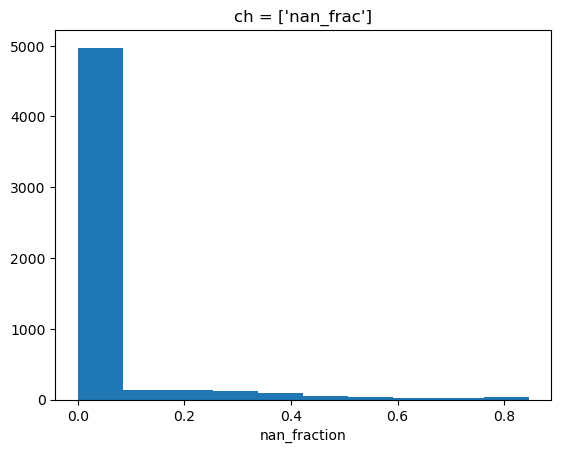

In [116]:
df_quality = pd.read_csv("quality.csv", index_col=0)
nans = df_quality["nan_fraction"]
nans = nans.to_xarray().rename(index="sample").expand_dims("ch")
nans = nans.assign_coords(sample=imgs.sample, ch=["nan_frac"])
# nans = np.power(nans, 1/2)

nans.plot.hist()

In [105]:
imgs_mean = imgs.mean(["i", "j"])
imgs_std = imgs.std(["i", "j"])
imgs_mean.sizes, imgs_std.sizes

(Frozen({'sample': 5635, 'ch': 5}), Frozen({'sample': 5635, 'ch': 5}))

In [150]:
imgs_stats = xr.concat([
    imgs_mean, 
    imgs_std, 
    nans
], dim="ch").compute()
imgs_stats

<xarray.DataArray (sample: 5635, ch: 11)>
array([[0.20906042, 0.21467054, 0.23049232, ..., 0.13281001, 0.07609304,
        0.        ],
       [0.36214238, 0.31972349, 0.38786289, ..., 0.17255801, 0.09090368,
        0.        ],
       [0.11555089, 0.11516159, 0.15471426, ..., 0.11302536, 0.08205374,
        0.        ],
       ...,
       [0.21112631, 0.23335612, 0.243426  , ..., 0.14076941, 0.07704724,
        0.        ],
       [0.35198635, 0.32972625, 0.45371348, ..., 0.19811727, 0.16548251,
        0.        ],
       [0.56245154, 0.58899629, 0.56204253, ..., 0.10187317, 0.07812747,
        0.        ]])
Coordinates:
  * sample   (sample) object 'AA498489' 'AA648736' ... 'ZZ830494' 'ZZ975262'
  * ch       (ch) object 'swir' 'nir' 'r' 'g' 'b' ... 'r' 'g' 'b' 'nan_frac'

Based on dimensionality, use min_pts=23!


23

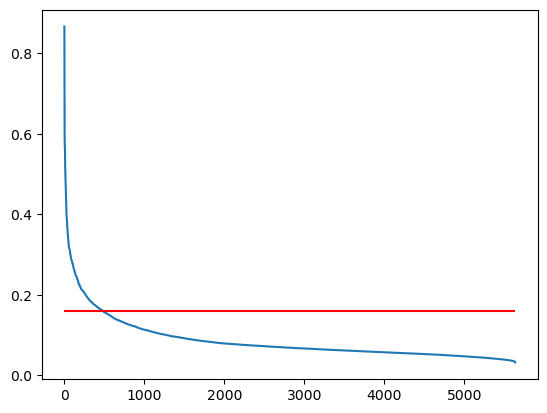

In [161]:
dbscan_knee_plot(imgs_stats, eps=.16)

In [162]:
# clst = DBSCAN(eps=.13, min_samples=21).fit(imgs_stats)
clst = DBSCAN(eps=.16, min_samples=23).fit(imgs_stats)

In [163]:
np.unique(clst.labels_, return_counts=True)

(array([-1,  0]), array([ 260, 5375]))

In [164]:
is_outlier = clst.labels_ == -1
imgs_outlier = imgs.sel(sample=is_outlier).load()
imgs_outlier

<xarray.DataArray (sample: 260, i: 350, j: 350, ch: 5)>
array([[[[1.        , 1.        , 1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        , 1.        , 1.        ],
         ...,
         [0.0644226 , 0.04018554, 0.1010742 , 0.14837645, 0.17141722],
         [0.06045531, 0.0389038 , 0.10565184, 0.14974974, 0.1741638 ],
         [0.06510925, 0.04091796, 0.09436034, 0.1477661 , 0.16867064]],

        [[1.        , 1.        , 1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        , 1.        , 1.        ],
         ...,
         [0.06556701, 0.03981933, 0.09893797, 0.14318846, 0.1755371 ],
         [0.06510925, 0.04128417, 0.10336302, 0.14440916, 0.17767332],
         [0.06266784, 0.04250488, 0.1010742 , 0.14318846, 0.17492674]],

        [[1.        , 1.        , 1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        , 1.        , 1.        ],
         ...,
...
         [0.8127899 , 0.7660767 , 0.45782468, 0.37619016, 0.18942259],
         [0.8127899 , 0.7659546 , 0.45812985, 0.37649533, 0.18972777],
         [0.8127136 , 0.76583254, 0.45828244, 0.3768005 , 0.19003294]],

        [[0.5395813 , 0.53109133, 0.5083313 , 0.4385986 , 0.31408688],
         [0.5631561 , 0.53109133, 0.48834226, 0.46347043, 0.33834836],
         [0.5474396 , 0.5219971 , 0.48834226, 0.4385986 , 0.30218503],
         ...,
         [0.8127899 , 0.7669312 , 0.45690915, 0.37512204, 0.18835448],
         [0.8127899 , 0.7668091 , 0.45721433, 0.37542722, 0.18865965],
         [0.8127136 , 0.76668704, 0.4575195 , 0.3757324 , 0.18896483]],

        [[0.55529785, 0.5037476 , 0.5083313 , 0.46347043, 0.31408688],
         [0.5710144 , 0.5128418 , 0.52801514, 0.48849484, 0.31408688],
         [0.5710144 , 0.5128418 , 0.52801514, 0.48849484, 0.31408688],
         ...,
         [0.8127899 , 0.76723635, 0.45690915, 0.37512204, 0.18835448],
         [0.8127899 , 0.7671143 , 0.45721433, 0.37542722, 0.18865965],
         [0.8127136 , 0.7669922 , 0.4575195 , 0.3757324 , 0.18896483]]]],
      dtype=float32)
Coordinates:
  * sample   (sample) object 'AB841632' 'AG525529' ... 'ZV974825' 'ZV999006'
  * ch       (ch) object 'swir' 'nir' 'r' 'g' 'b'
Dimensions without coordinates: i, j

In [165]:
random_samples = np.random.choice(imgs_outlier.sample, size=25)
random_samples

array(['LP931161', 'YZ830889', 'AB841632', 'KD407757', 'LV760914',
       'KA209678', 'LT442406', 'PK740006', 'NZ957111', 'AB841632',
       'SH612997', 'LG759253', 'CN860206', 'MT475354', 'PC118570',
       'BS186345', 'WE487519', 'KH315815', 'RQ423804', 'ON629837',
       'EX130915', 'AT713455', 'HY800917', 'MH337949', 'PZ394158'],
      dtype=object)

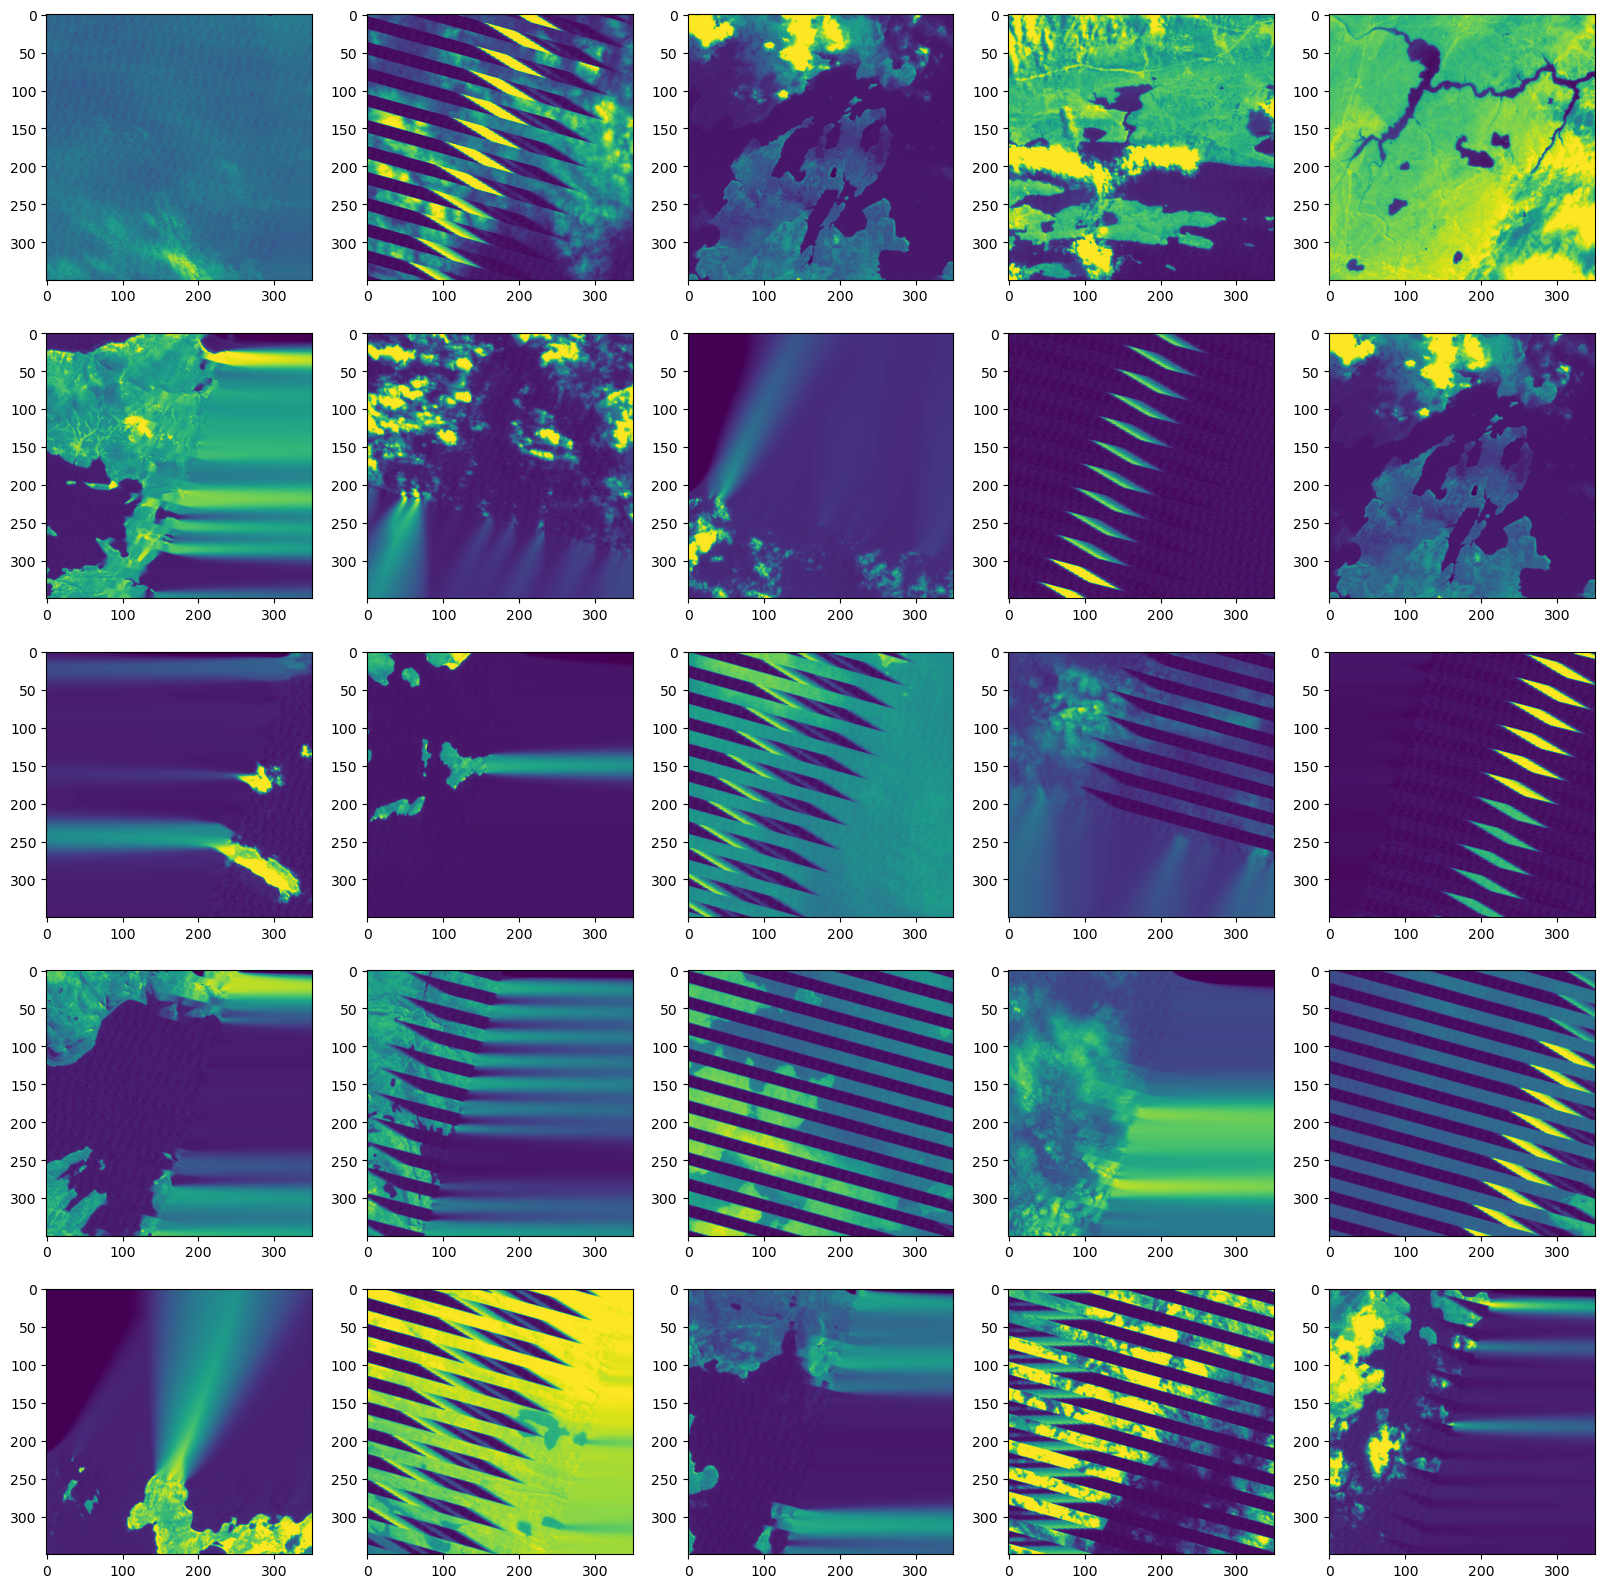

In [166]:
fig, axarr = plt.subplots(ncols=5, nrows=5, figsize=(20, 20))
for s, ax in zip(random_samples, axarr.ravel()):
    ax.imshow(imgs_outlier.sel(sample=s).isel(ch=0))

In [176]:
pd.Series(is_outlier).to_csv("is_outlier.csv")

In [177]:
pd.read_csv("is_outlier.csv")["0"]

0       False
1       False
2       False
3       False
4       False
        ...  
5630    False
5631    False
5632    False
5633    False
5634    False
Name: 0, Length: 5635, dtype: bool

# Application to test data 
(irrelevant because I need to predict on all of them anyway)

In [135]:
kelp_test = KelpNCDataset(img_nc_path="data_ncf/test_imgs_fe.nc")
imgs_test = kelp_test.imgs.chunk(sample=250).isel(ch=slice(0, 5))
imgs_test

<xarray.DataArray (sample: 1426, i: 350, j: 350, ch: 5)>
dask.array<getitem, shape=(1426, 350, 350, 5), dtype=float32, chunksize=(250, 350, 350, 5), chunktype=numpy.ndarray>
Coordinates:
  * sample   (sample) object 'AA408972' 'AA804258' ... 'ZY575159' 'ZY737533'
  * ch       (ch) object 'swir' 'nir' 'r' 'g' 'b'
Dimensions without coordinates: i, j

In [146]:
imgs_stats_test = xr.concat([
    imgs_test.mean(["i", "j"]), 
    imgs_test.std(["i", "j"]), 
    # nans
], dim="ch").compute()
imgs_stats_test

<xarray.DataArray (sample: 1426, ch: 10)>
array([[0.18238531, 0.18864015, 0.18128088, ..., 0.11908626, 0.09744073,
        0.05089277],
       [0.11135238, 0.10844993, 0.21911119, ..., 0.12512067, 0.10404019,
        0.07239998],
       [0.52449304, 0.54484725, 0.40798748, ..., 0.15651748, 0.14327797,
        0.11491676],
       ...,
       [0.10931216, 0.08564588, 0.19186269, ..., 0.15106139, 0.14959213,
        0.16735882],
       [0.26117545, 0.26636314, 0.39870435, ..., 0.2195708 , 0.20342773,
        0.174183  ],
       [0.48855865, 0.49543995, 0.494037  , ..., 0.17035095, 0.15598944,
        0.13864835]], dtype=float32)
Coordinates:
  * sample   (sample) object 'AA408972' 'AA804258' ... 'ZY575159' 'ZY737533'
  * ch       (ch) object 'swir' 'nir' 'r' 'g' 'b' 'swir' 'nir' 'r' 'g' 'b'

In [149]:
np.unique(clst.fit_predict(imgs_stats_test), return_counts=True)

(array([-1,  0]), array([  95, 1331]))